## Create a negative joke dataset


In [4]:
import importlib
import nojokes
import prejokes
from prejokes import JokePreprocessor
import pandas as pd
from sklearn.model_selection import train_test_split 
import statistics 
from statistics import mode
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from nltk.tokenize import sent_tokenize
import seaborn as sns
%matplotlib inline  

## Characteristics and requirements of the negative jokes

The negative jokes should be similar to the real jokes regarding the following features:
* style (narrative, fictional)
* length (number of sentences)
* vocabulary 
* syntactic features (word classes etc.)  

#### Style
In order to collect texts that follow a certain narrative structure, the negative jokes will be drawn from a dataset of American movie plots from Wikipedia.  


#### Length
The movie plots in the dataset are longer than a single joke. To encounter this issue, the following methodology will be applied:
1. Find the average length (number of sentences) in the jokes dataset.
2. Split the movie plot dataset into sentence n-grams according to the determined length


In [5]:
jokes_file = '../data/s3_curated_jokes.csv'
jp = JokePreprocessor()
joke_df = jp.load(jokes_file)
joke_df['Sentence_count'] = joke_df['Joke'].apply(lambda x: jp.count_sentences(x))

In [6]:
joke_df.shape

(28471, 2)

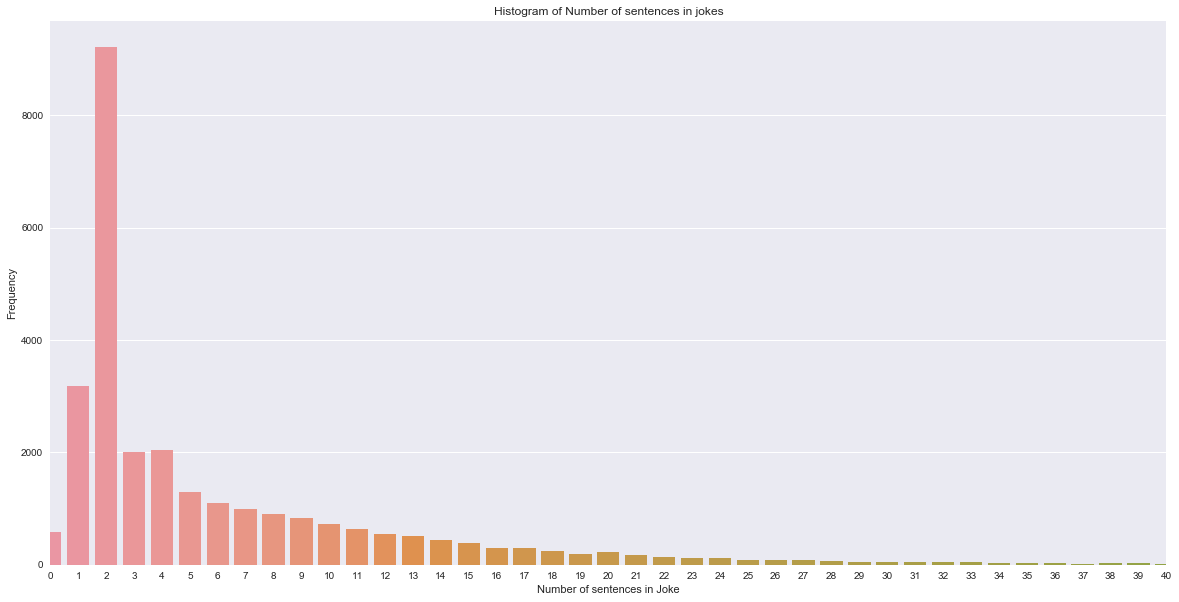

In [9]:
xlim = 40
plt.figure(figsize=(20, 10))
histo = sns.countplot( joke_df['Sentence_count'])
plt.xlim(0, 40)
plt.xlabel('Number of sentences in Joke')
plt.ylabel('Frequency')
plt.title('Histogram of Number of sentences in jokes')
histo.figure.savefig("../plots/joke_sentence_frequencies.png")

#sns.set(rc={'figure.figsize':(50,50)})




#### Average length and median

In [4]:
mean = joke_df['Sentence_count'].mean()
median = joke_df['Sentence_count'].median()

print('Mean: ' + str(mean))
print('Median: ' + str(median))

Mean: 7.106599697938253
Median: 3.0


#### Split movie plot data into sentence n-grams

In [ ]:
jp = JokePreprocessor()
importlib.reload(nojokes)

In [5]:
movieplots_file = '../data/plotdata.txt'
with open(movieplots_file) as file:
    movieplots = file.read().strip().split('\n\n\n\n\n\n')
plot_df = pd.DataFrame(movieplots)
plot_df.columns = ['plot']
plot_df = jp.sentence_n_grams_split(plot_df, 'plot', 6)
plot_df.columns = ['nonjoke']

In [8]:
# this df holds all sentence ngrams
outfile = '../data/movieplots_6gram.csv'
plot_df.to_csv(outfile)

In [ ]:
df = nojokes.mysql_import('eng_wikipedia_2016_1M','sentences')
df= df.drop([0], axis = 1)
df = df.rename(columns={1:'sentence'})
df = jp.remove_punctuation(df, 'sentence')
df = jp.replace_numbers(df, 'sentence')
df = jp.clean_and_tokenize(df, 'sentence')
df.to_csv(out_file)

#### Filter jokes by number of sentences

In [17]:
outfile = '../data/jokes_6gram.csv'
filtered_jokes = jp.filter_by_joke_len(joke_df, 'Sentence_count', 6)
# this df holds all joke ngrams
filtered_jokes = filtered_jokes['Joke'].reset_index(drop=True)
filtered_jokes = filtered_jokes.drop(['0'], axis =1)
filtered_jokes.columns = ['joke']
filtered_jokes.to_csv(outfile)

# Calculate Similarities

#### Joke Dataset

In [2]:
jokefile = '../data/jokes_6gram.csv'
joke_df = pd.read_csv(jokefile, index_col=0)
joke_df.head()

,joke
0,A blonde is walking down the street with her ...
1,"A blonde, a brunette and a redhead were walki..."
2,There was a blonde woman who was having finan...
3,This blonde had a near death experience the o...
4,"Two blondes are walking down a road, one has ..."


#### Nonjoke-Dataset

In [3]:
nonjokefile = '../data/movieplots_6gram.csv'
nonjoke_df = pd.read_csv(nonjokefile, index_col=0)
nonjoke_df.columns = ['nonjoke']
nonjoke_df.head()

,nonjoke
0,"After three years in prison, Cruella de Vil ha..."
1,Cruella therefore mends her working relationsh...
2,"Cruella's probation officer, Chloe Simon, neve..."
3,"Dipstick's mate, Dottie, has recently given bi..."
4,"To mend her reputation, Cruella buys the Secon..."


For every joke in the Joke Dataset: Calculate the similarity of each document in the Nonjoke-Dataset

### Preprocess text data

In [4]:
jp = JokePreprocessor()
joke_df = jp.clean_and_tokenize_spacy(joke_df, 'joke')
joke_df.head()

,joke_spacy_vectorized
0,blonde walking street blouse open exposing one...
1,blonde brunette redhead walking along beach se...
2,blonde woman financial troubles decided kidnap...
3,blonde near death experience day climbed top h...
4,two blondes walking road one large sports bag ...


In [5]:
nonjoke_df = jp.clean_and_tokenize_spacy(nonjoke_df, 'nonjoke')
nonjoke_df.head()

,nonjoke_spacy_vectorized
0,three years prison cruella de vil cured desire...
1,cruella therefore mends working relationship v...
2,cruellas probation officer chloe simon neverth...
3,dipsticks mate dottie recently given birth thr...
4,mend reputation cruella buys second chance dog...


In [6]:
jokes_tokenized = '../data/jokes_6gram_clean_tokenized_spacy.csv'
nonjokes_tokenized = '../data/movieplots_6gram_clean_tokenized_spacy.csv'
joke_df.to_csv(jokes_tokenized)
nonjoke_df.to_csv(nonjokes_tokenized)


### Build similarity df

In [7]:
jokes_tokenized = '../data/jokes_6gram_clean_tokenized_spacy.csv'
nonjokes_tokenized = '../data/movieplots_6gram_clean_tokenized_spacy.csv'
jokes_df = pd.read_csv(jokes_tokenized, index_col=0)
nonjokes_df = pd.read_csv(nonjokes_tokenized, index_col=0)

In [8]:
jokes_df.head()

,joke_spacy_vectorized
0,blonde walking street blouse open exposing one...
1,blonde brunette redhead walking along beach se...
2,blonde woman financial troubles decided kidnap...
3,blonde near death experience day climbed top h...
4,two blondes walking road one large sports bag ...


In [9]:
nonjokes_df.head()

,nonjoke_spacy_vectorized
0,three years prison cruella de vil cured desire...
1,cruella therefore mends working relationship v...
2,cruellas probation officer chloe simon neverth...
3,dipsticks mate dottie recently given birth thr...
4,mend reputation cruella buys second chance dog...


In [5]:
jp = JokePreprocessor()
test1 = jokes_df.loc[:3,]
test2 = nonjokes_df.loc[:3,]
sim_df = jp.similarity_matrix(test1, test2, 'joke_spacy_vectorized')
sim_df

/Users/miriamamin/Documents/Digital_Humanities/WS1920/DH_Methods_Applications/joke-detection/source/prejokes.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  similarity_matrix[col_name] = similarity_matrix[col_name].apply(lambda x: nlp(x))
/Users/miriamamin/Documents/Digital_Humanities/WS1920/DH_Methods_Applications/joke-detection/source/prejokes.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  similarity_matrix[str(i)] = similarity_matrix[col_name].apply(lambda x: x.similarity(compare_sentence))


,joke_spacy_vectorized,0,1,2,3
0,"(blonde, walking, street, blouse, open, exposi...",0.768916,0.780419,0.772973,0.782157
1,"(blonde, brunette, redhead, walking, along, be...",0.735404,0.761470,0.757716,0.767174
2,"(blonde, woman, financial, troubles, decided, ...",0.813459,0.824281,0.816462,0.816263
3,"(blonde, near, death, experience, day, climbed...",0.806541,0.805204,0.788450,0.803720


In [8]:
sim_file = '../data/jokes_plots_similarity_matrix.csv'
sim_df = jp.similarity_matrix(jokes_df, nonjokes_df, 'joke_spacy_vectorized')
sim_df.to_csv(sim_file)

In [16]:
sim = pd.read_csv(sim_file, index_col=0)

In [17]:
sim.head()

,joke_spacy_vectorized,0,1,2,3,4,5,6,7,8,...,80887,80888,80889,80890,80891,80892,80893,80894,80895,80896
0,blonde walking street blouse open exposing one...,0.768916,0.780419,0.772973,0.782157,0.779820,0.793865,0.794668,0.780983,0.787238,...,0.805387,0.819452,0.814907,0.790211,0.801959,0.761341,0.777736,0.777638,0.780524,0.786606
1,blonde brunette redhead walking along beach se...,0.735404,0.761470,0.757716,0.767174,0.768464,0.785410,0.789437,0.775253,0.785369,...,0.771764,0.798279,0.782547,0.756935,0.771122,0.728684,0.753059,0.769201,0.768211,0.761647
2,blonde woman financial troubles decided kidnap...,0.813459,0.824281,0.816462,0.816263,0.820096,0.831758,0.840081,0.820179,0.830219,...,0.803248,0.827226,0.819045,0.802016,0.819393,0.773274,0.801880,0.789971,0.803356,0.812936
3,blonde near death experience day climbed top h...,0.806541,0.805204,0.788450,0.803720,0.804592,0.811490,0.814848,0.812040,0.840169,...,0.803359,0.822400,0.808613,0.789673,0.817771,0.777521,0.798096,0.792132,0.808071,0.810877
4,two blondes walking road one large sports bag ...,0.679027,0.715490,0.712649,0.697434,0.697006,0.717648,0.732784,0.703273,0.711509,...,0.657983,0.684555,0.667537,0.638647,0.659663,0.624299,0.652098,0.652411,0.662270,0.662195


### Find document with max value for each row

In [42]:
most_similar_df = sim.drop('joke_spacy_vectorized', axis=1).idxmax(axis=1)
similarity_scores = sim.drop('joke_spacy_vectorized', axis=1).max(axis=1)

In [56]:
jokefile = '../data/jokes_6gram.csv'
joke_df = pd.read_csv(jokefile, index_col=0)
nonjokefile = '../data/movieplots_6gram.csv'
nonjoke_df = pd.read_csv(nonjokefile, index_col=0)
joke_df['most_similar_index'] = most_similar_df
joke_df['similarity_score'] = similarity_scores
joke_df['most_similar_plot_ngram'] = joke_df['most_similar_index'].apply(lambda x: nonjoke_df.loc[int(x), 'joke_ngram'])

In [44]:
joke_df.head()

,joke,most_similar_index,similarity_score,most_similar_plot_ngram
0,A blonde is walking down the street with her ...,28453,0.889712,"Finally, Sue walks down Hollywood Boulevard, a..."
1,"A blonde, a brunette and a redhead were walki...",28469,0.899478,"The two women kiss, before Nikki fades away in..."
2,There was a blonde woman who was having finan...,12180,0.933163,Basil then reveals that he can't go on the hei...
3,This blonde had a near death experience the o...,11772,0.931980,"In one instance, she woke up screaming and her..."
4,"Two blondes are walking down a road, one has ...",31107,0.896209,The two steal a car (a 1996 Impala SS sedan) a...


In [50]:
i = 800
print(joke_df.loc[i, 'joke'])
print('---')
print(joke_df.loc[i, 'most_similar_plot_ngram'])

 A director decides that he's going to make a movie based on the lives of famous classical composers. Looking for a prospective cast, he asks Sylvester Stallone which composer he would like to play in the movie. Stallone thinks for a moment and says, "I like Mozart. Let me be Mozart." The director then turns to Arnold Schwarzenegger and asks him who he'd like to play. Arnold replies, "I'll be Bach!" 
---
Tom is thrilled to meet Eddie and see inside his trailer and be on a film set, also to play the Xbox, since Tom doesn’t have one at his Pop's house. Eddie says that his mom doesn’t care how much he plays the Xbox in his spare time, because she is so busy. Tom tells Eddie how lucky he is, in comparison to him, but he's a friend of the former actor, Milles. Eddie doesn’t seem impressed by this, though, having never heard of Milles or other actors that Tom speaks about. Tom notices that Eddie doesn’t seem to appear that interested in acting, choosing to concentrate mainly on his Xbox that

In [64]:
outfile = '../data/joke_classifier_dataset.csv'
joke_classifier_df = joke_df.copy()
joke_classifier_df.drop(['most_similar_index', 'similarity_score'],axis=1, inplace=True)
joke_classifier_df.columns = ['joke', 'nonjoke']
joke_classifier_df.to_csv(outfile)

In [65]:
joke_classifier_df.shape

(1108, 2)